In [33]:
# Parameters
artificial_humans = "../../data/artificial_humans/01_rnn_edge_features/model/rnn_True__edge_True__global_features_False.pt"
artificial_humans_model = "graph"
manager = "../../data/human_like_manager/03_features/model/features_cont+ppun+valid.pt"
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 1000


In [34]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
rec_keys = [
    'punishments', 'contributions', 'common_good', 'contributor_payoff', 'manager_payoff']

def run_batch(manager, env):
    state = env.reset()
    metric_list = []
    for round_number in count():      
        encoded = manager.encode_pure(state)
        
        batch_structure = env.get_batch_structure()

        obs = {**encoded, **batch_structure}

        # Get q values from controller
        action = manager.punishments(obs, first=round_number == 0)

        state = env.punish(action)
        
        metrics = {k: state[k].to(th.float).mean().item() for k in rec_keys}

        # pass actions to environment and advance by one step
        state, reward, done = env.step()
    
        metrics['next_reward'] = reward.mean().item()
        metrics['round_number'] = round_number
        metric_list.append(metrics)
         
        if done:
            break
    return metric_list

In [36]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)

mg = GraphNetwork.load(manager, device=device)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, 
    n_rounds=n_episode_steps, batch_size=n_episodes, device=device)

recorder = Memory(n_episodes=1, n_episode_steps=n_episode_steps, output_file=None, device=device)

state = env.reset()
for round_number in count():
    print(round_number)
    _state = {**state, **env.get_batch_structure()}
    encoded = mg.encode_pure(_state)

    action, proba = mg.predict_pure(encoded, reset_rnn=round_number == 0, sample=True)

    state = env.punish(action)

    recorder.add(**{k: v.squeeze(-1) for k, v in state.items()}, episode_step=round_number)
    state, reward, done = env.step()
    if done:
        break
# recorder.next_episode(episode)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
state = env.reset()
state['contributions']

tensor([[ 5],
        [10],
        [15],
        ...,
        [15],
        [ 4],
        [ 8]])

In [ ]:
recorder.memory['punishments'].shape

torch.Size([1, 16, 4000])

In [ ]:
columns = ['round_number','participant_code']

punishments = using_multiindex(recorder.memory['punishments'][0].numpy(), columns=columns, value_name='punishment')
common_good = using_multiindex(recorder.memory['common_good'][0].numpy(), columns=columns, value_name='common_good')
contributions = using_multiindex(recorder.memory['contributions'][0].numpy(), columns=columns, value_name='contribution')

df_sim = punishments.merge(common_good).merge(contributions)
df_sim['data_source'] = 'simulation'

data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"
experiment_names = ['trail_rounds_2']

df_pilot = pd.read_csv(data_file)

# df_pilot = df_pilot[df_pilot['experiment_name'].isin(experiment_names)]
df_pilot['data_source'] = 'pilot ' + df_pilot['experiment_name']

columns = ['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'data_source']

df = pd.concat([df_sim, df_pilot[columns]]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source'], 
    value_vars=['punishment', 'contribution'])

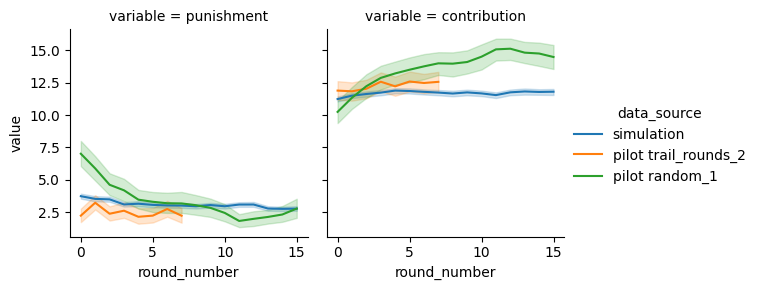

In [ ]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="line",
    height=3, aspect=1,
)


In [ ]:
dfm.groupby(['round_number', 'data_source', 'variable'])['value'].mean().head(10)

round_number  data_source           variable    
0             pilot random_1        contribution    10.239796
                                    punishment       7.000000
              pilot trail_rounds_2  contribution    11.889535
                                    punishment       2.206395
              simulation            contribution    11.234000
                                    punishment       3.714250
1             pilot random_1        contribution    11.336735
                                    punishment       5.862245
              pilot trail_rounds_2  contribution    11.834302
                                    punishment       3.206395
Name: value, dtype: float64

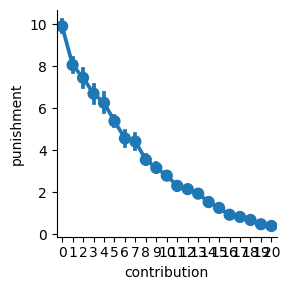

In [ ]:
g = sns.catplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    kind="point",
    height=3, aspect=1,
)